In [274]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics, Random
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

In [263]:
T = 180
N = 100
# c = 3
# gg = erdos_renyi(N, c/N)
k = 4
gg = random_regular_graph(N, k)
g = IndexedGraph(gg)
λ = 0.015
ρ = 0.022
γ = 0.1;

In [264]:
rng = MersenneTwister(111)
sis = SIS(g, λ, ρ, T; γ)
bp = mpbp(sis)
cb = CB_BP(bp);

In [265]:
obs_times = [40, 100, 160]
nobs = N * length(obs_times) * 2 ÷ 3 * 3 ÷ 2
obs_fraction = N / nobs
X, observed = draw_node_observations!(bp, nobs, times = obs_times .+ 1, softinf=Inf; rng);

In [266]:
svd_trunc = TruncBond(6)
iters, cb = iterate!(bp, maxiter=200; svd_trunc, cb, tol=1e-3);

Running MPBP: iter 6 	 Time: 0:05:31
  Δ:  0.0004394126524415924

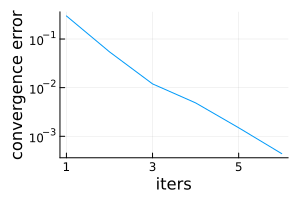

In [267]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [268]:
b_bp = beliefs(bp)
p_bp = [[bᵗ[INFECTED] for bᵗ in bb] for bb in b_bp];

In [269]:
true_infections = [UnitRange{Int64}[] for _ in 1:N]
for i in 1:N
    start = -1
    for t in 1:T+1
        if X[i,t] == INFECTED
            start == -1 && (start = t)
        else
            start != -1 && ( push!(true_infections[i], start-1:t-2); start = -1 )
        end
    end
    start != -1 && push!(true_infections[i], start-1:T)
end

In [270]:
using ColorSchemes
cg = cgrad(:deep)[1:150]
cg = cgrad(:GnBu_3, rev=true)
cg = cgrad(:haline)[150:end]
cg = cgrad(:tokyo, rev=false)[50:end]
cg = cgrad(:viridis, alpha=1.0)[80:end]
cg = cgrad([theme_palette(:auto)[1], :yellow], 0.6)

In [271]:
X_bp = reduce(hcat, p_bp)
pl = heatmap(1:N, 0:T, X_bp, c=cg, xlabel="i", ylabel="t", colorbar_title="\$P(x_i^t=I)\$");

In [272]:
label = "true infections"
for i in 1:N
    for a in true_infections[i]
        plot!(pl, [i,i], [a.start-0.3,a.stop+0.3], c=:black, label=label, lw=1)
        label = ""
    end
end

Observations at times: [40, 100, 160]


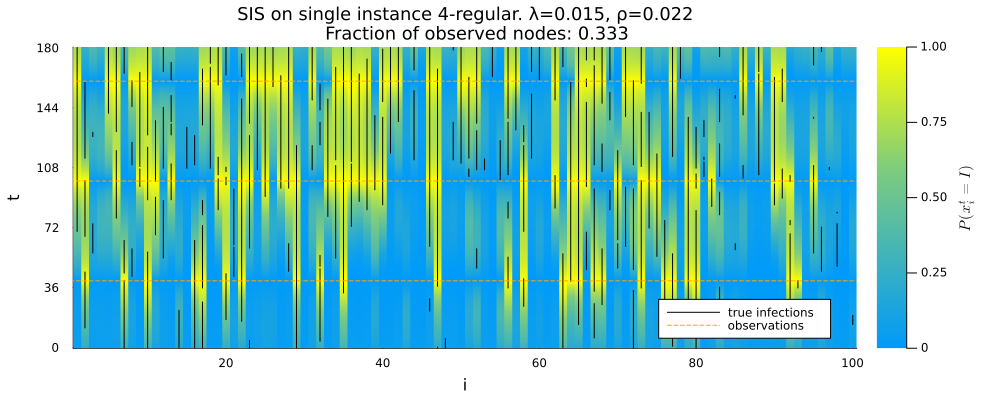

In [273]:
pl2 = deepcopy(pl)
hline!(pl2, obs_times, c=:orange, ls=:dash, label="observations", legend=:outertopright,
    size=(1000,400))
println("Observations at times: ", obs_times)
plot(pl2, margin=5Plots.mm, 
    title="SIS on single instance $k-regular. λ=$(round(λ, digits=3)), ρ=$(round(ρ, digits=3))
    Fraction of observed nodes: $(round(obs_fraction, digits=3))", 
    titlefontsize=12, size=(1000,400), legend=:bottomright, yticks=0:(T÷5):T, widen=false)

In [276]:
jldsave("plot_data/sis_inference_single_instance.jld2"; 
    N, T, X_bp, true_infections, obs_times, k, λ, ρ, obs_fraction);

In [ ]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [ ]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
ns = 10^5
sample!(sms, ns)
b_mc = marginals(sms)
p_mc = [[bbb[2] for bbb in bb] for bb in b_mc];

In [ ]:
title = @sprintf "Monte Carlo %.0e samples" length(sms.X)
pl_mc = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:10:T, title=title)
for i in 1:N
    plot!(pl_mc, 0:T, p_mc[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_bp = plot(xlabel="time", ylabel="\$P(x_i=I)\$", xticks=0:10:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, p_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_sc = scatter(reduce(vcat, p_bp), reduce(vcat, p_mc), xlabel="MPBP", ylabel="MonteCarlo", 
    label="\$P(x_i=I)\$", ms=3, c=:black, legend=:outertopright)
plot!(identity, label="", size=(300,300))
println("SIS on Erdos_renyi with N=$N, c=$c. P(S→I)=$λ, P(I→S)=$ρ. P(zero patient)=", round(γ, digits=3))
println("$nobs random node observations at final time.")
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outertopright, 
    margin=5Plots.mm, layout=(1,3))